In [263]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
mpl.rcParams["figure.dpi"] = 120 

In [264]:
def get_oracles(funcs, oracle_getter):
    print('get_oracles', len(funcs))
    return {func: oracle_getter(func) for func in funcs}

def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] =-1 if instance[i] == 1 else 1
        oracles[instance] = oracle
        
    return oracles

def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles
def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)

def get_oracle_diffs(oracles, prod=True, mat=False, keys=None):
    oracle_diffs = {} 
    if keys is None:
        keys = list(oracles.keys())
    # keys.sort()
    for v1 in keys:
        for v2 in keys:
            if prod:
                oracle_diffs[(v1, v2)] = np.eye(oracles[v1].shape[0])- oracles[v1].T @ oracles[v2]
            else:
                # print('normal diff')
                oracle_diffs[(v1, v2)] = oracles[v1] - oracles[v2]
    if mat:
        oracle_diffs =  [
            [
                oracle_diffs[(k1, k2)] for k1 in keys
            ] for k2 in keys
        ]
    return oracle_diffs
def permutation_oracle(perm):
    n = len(perm)
    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[i, perm[i]] = 1
    return oracle

def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles

def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n,n):
        # print(to_str(perm))
        if perm.index(0) >= n//2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [265]:
def get_cycles(n, k):
    perm = tuple(range(n))
    yes_instances = set()
    for cycle_points in itertools.permutations(perm, k):
        curr_cycle = list(perm)
        for i in range(k-1):
            curr_cycle[cycle_points[i]] = cycle_points[i+1]
        curr_cycle[cycle_points[-1]] = cycle_points[0]
        yes_instances.add(tuple(curr_cycle))
    return list(yes_instances)
def num_fixed_points(perm):
    curr_sum = 0
    for i in range(len(perm)):
        if perm[i] == i:
            curr_sum += 1
    return curr_sum

def permutation_thresh(n, k):
    # perm = nkp.array(range(n))
    no_instances = set()
    yes_instances = set()
    for perm in itertools.permutations(tuple(range(n))):
        num_fixed = num_fixed_points(perm)
        if num_fixed == k:
            no_instances.add(perm)
        elif num_fixed == k + 1:
            yes_instances.add(perm)
    return Problem(list(no_instances), list(yes_instances))
def equality(n):
    perms = list(itertools.permutations(list(range(n))))
    no_instances = []
    yes_instances = [tuple(perm + tuple(p + n for p in perm)) for perm in perms]
    for perm1, perm2 in itertools.combinations_with_replacement(perms, 2):
        instance = tuple(perm1+ tuple(p + n for p in perm2))
        if dist(perm1, perm2) == 2:
            no_instances.append(instance)
    return Problem(no_instances, yes_instances)


def fixed_points(n, k):
    no_instances = []
    yes_instances = []
    for perm in itertools.permutations(range(n)):
        fp = num_fixed_points(perm)
        if fp == k:
            no_instances.append(perm)
        elif fp == k+1:
            yes_instances.append(perm)
    return Problem(no_instances, yes_instances)
        
def cycle0(n, k):
    no_instances = [cycle for cycle in get_cycles(n, k) if cycle[0] != 0]
    yes_instances = [cycle for cycle in get_cycles(n, k+1) if cycle[0] != 0]
    return Problem(no_instances, yes_instances)
def cycle(n, k, k2=None):
    if k2 is None:
        k2 = k+1
    no_instances = get_cycles(n,k)
    yes_instances = get_cycles(n, k2)
    return Problem(no_instances, yes_instances)

def preimage(n, k):
    # perms = list(itertools.permutations(range(n)))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n, k):
        preimage0 = perm.index(0)
        # print(preimage0, perm)
        if preimage0 % 2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    # print(no_instances)
    # print(yes_instances)
    return Problem(no_instances, yes_instances)
def get_all_cycles(perm):
    cycles =[]
    points_in_cycles = set()
    for i in range(n):
        if i not in points_in_cycles and perm[i] != i:
            cycle = [i]
            j = perm[i]
            points_in_cycles.add(j)
            while j not in cycle:
                cycle.append(j)
                j = perm[j]
                points_in_cycles.add(j)
            cycles.append(tuple(cycle))
    return cycles

def num_cycles(perm):
    return len(get_all_cycles(perm))
        
def transpose_thresh(n, k):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in perms:
        cycles = get_all_cycles(perm)
        cycle_lengths = set(len(cycle)  for cycle in cycles)
        if cycle_lengths == set([2]):
            if len(cycles) == k:
                no_instances.append(perm)
            elif len(cycles) == k+1:
                yes_instances.append(perm)
    return Problem(no_instances, yes_instances)

def transpose(n, easy=False):
    perm = tuple(range(n))
    no_instances = []
    if easy:
        for i in range(n//2):
            instance = list(perm)
            instance[2*i] = 2*i + 1
            instance[2*i+1] = 2*i
            no_instances.append(tuple(instance))
    else:
        for i,j in itertools.combinations(perm, 2):
            # print(i,j)
            instance = list(perm)
            instance[i] = j
            instance[j] = i
            no_instances.append(tuple(instance))
    return Problem([perm], list(no_instances))

def relative_hadamard_norm_min(mat, relative, D1_len):
    mat_len = mat.shape[0]
    mat_size = mat_len
    D1 = list(range(D1_len))
    D2 = list(range(D1_len, mat_size))
    relative_shape = relative[0][0].shape
    t = cp.Variable(nonneg=True)
    X = [[cp.Variable(relative_shape) for _ in range(mat_len)] for _ in range(mat_len)]
    for x in D1:
        for y in D2:
            X[x][y] = cp.Variable(relative_shape)
    constraints = [cp.bmat(X) >> 0]
    constraints += [
        mat[x][y] == cp.trace(X[x][y].T @ relative[x][y]) 
        for x in range(mat_size) for y in range(mat_size)
    ]
    constraints += [
        t >= cp.trace(X[z][z]) for z in range(mat_size)
    ]
    
    opt_prob = cp.Problem(cp.Minimize(t), constraints)
    opt_prob.solve(verbose=True) 
    for x in range(mat_size):
        for y in range(mat_size):
            X[x][y] = X[x][y].value
    return X
    
def relative_hadamard_norm_max(mat, relative_mat, D1_len, solver="MOSEK"):
    print('shapes', )
    relative_shape = [0,0]
    relative_shape[0] = relative_mat.shape[0] // mat.shape[0]
    relative_shape[1] = relative_mat.shape[1] // mat.shape[1]
    relative_shape = tuple(relative_shape)
    D1 = list(range(mat.shape[0]))
    D2 = list(range((mat.shape[1]))) 
    
    # print(D1_len, len(D2), relative.shape)
    # relative_mat = np.block(relative)

    print(relative_mat.shape)
    mu = cp.Variable((len(D1)+len(D2)), nonneg=True)
    Lambda = cp.Variable((len(D1), len(D2)))
    print(relative_shape)
    Lambda_relative = cp.kron(Lambda, np.ones(relative_shape))
    Lambda_square_relative = cp.bmat([
        [np.zeros((Lambda_relative.shape[0], Lambda_relative.shape[0])), Lambda_relative
        ],
        [Lambda_relative.T, np.zeros((Lambda_relative.shape[1], Lambda_relative.shape[1]))]
    ])
    Lambda_relative = cp.multiply(Lambda_relative, relative_mat)
    diag = cp.kron(cp.diag(mu), np.eye(relative_shape[0]))
    # print(W.shape, diag.shape)
    W = Lambda_square_relative + diag
    # print(W)
    constraints = [cp.sum(mu) == 1, W >> 0]
    opt_prob = cp.Problem(cp.Maximize(2 * cp.trace(Lambda.T@mat)), constraints)
    opt_prob.solve(verbose=True, solver=solver, mosek_params= {"MSK_IPAR_NUM_THREADS": 8}) 
    return Lambda.value, mu.value

def to_adversary_mat(Lambda, mu):
    G = np.zeros(Lambda.shape)
    for x in range(Lambda.shape[0]):
        for y in range(Lambda.shape[1]):
            G[x,y] = Lambda[x,y]/np.sqrt(mu[x] * mu[ y])
            
    return G

In [266]:
def search_perm_sorter(perms):
    n = len(perms[0])
    perm_types = {i:[] for i in range(n)}
    for perm in perms:
        perm_types[perm.index(0)].append( perm)
    for t in perm_types:
        perm_types[t].sort()
    perm_assignment = {}
    curr_perm = 0
    for i, permsi in perm_types.items():
        permsi = list(permsi)
        for perm in permsi:
            perm_assignment[perm] = curr_perm
            curr_perm += 1
    print(perm_assignment)
    return perm_assignment, perm_types

def search_mask(funcs, assignment=None):
    size = len(funcs)
    if assignment is None:
        assignment = search_perm_sorter(funcs)
    # print(size)
    mask = np.zeros((size, size))
    for f in funcs:
        f0 = f.index(0)
        for g in funcs:
            g0 = g.index(0)
            if f0 != g0:
                mask[assignment[f], assignment[g]] = 1
    return mask

{(2, 0, 3, 1): 0, (3, 0, 1, 2): 1, (1, 3, 0, 2): 2, (3, 2, 0, 1): 3, (1, 2, 3, 0): 4, (2, 3, 1, 0): 5}
get_oracles 6


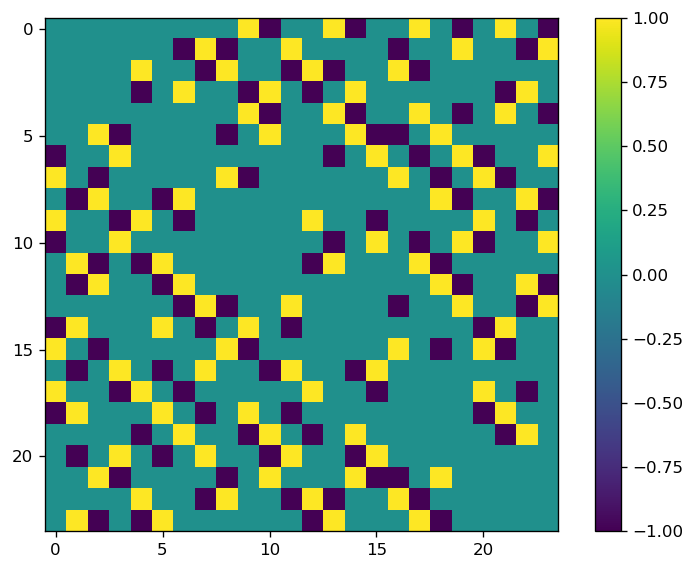

boop
['2031', '1302', '3012', '2310', '3201', '1230']
['2031', '1302', '3012', '2310', '3201', '1230']
(6, 6)
6


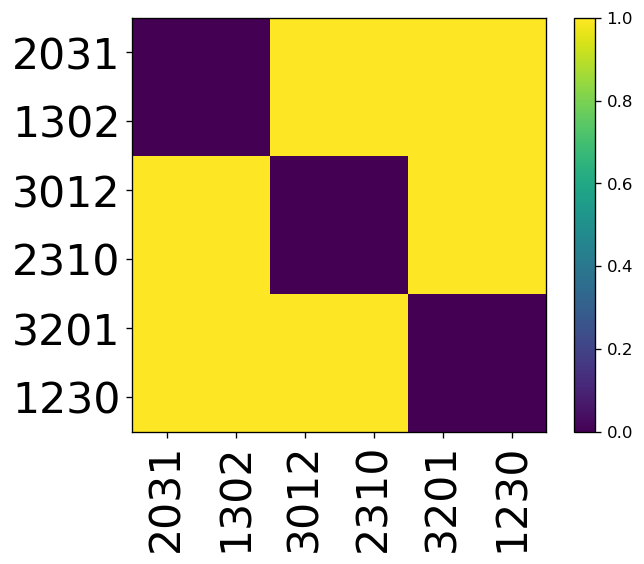

shapes
(24, 24)
(4, 4)
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 27 06:10:39 PM: Your problem has 48 variables, 2 constraints, and 0 parameters.
(CVXPY) May 27 06:10:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 27 06:10:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 27 06:10:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 27 06:10:39 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 27 06:10:39 PM: Compiling problem (ta

In [278]:
n = 4
k = 2
perms = get_cycles(n,n)
# perms = [perm for perm in perms.instances if perm.index(0)!=0]


# perms = list(itertools.permutations(range(n)))
# perms = perms[:3] + perms[-2:]
keys, perm_types = search_perm_sorter(perms)
# print(len(perms), len(keys))
oracles = get_oracles(perms, permutation_oracle)
# print(len(oracles))
oracle_diffs_list = get_oracle_diffs(oracles, prod=False, mat=True, keys=keys)
# print('blah', len(oracle_diffs_list), len(oracle_diffs_list[0]), oracle_diffs_list[0][0].shape)
# print(oracle_diffs_list)
oracle_diffs = np.block(oracle_diffs_list)

visualize(oracle_diffs)
mat = search_mask(perms, assignment=keys)
print('boop')
visualize(mat, (perms, perms), to_string=True)
start = time()
Lambda, mu = relative_hadamard_norm_max(mat, oracle_diffs, len(perms), solver="MOSEK")

print("time",  time()-start)

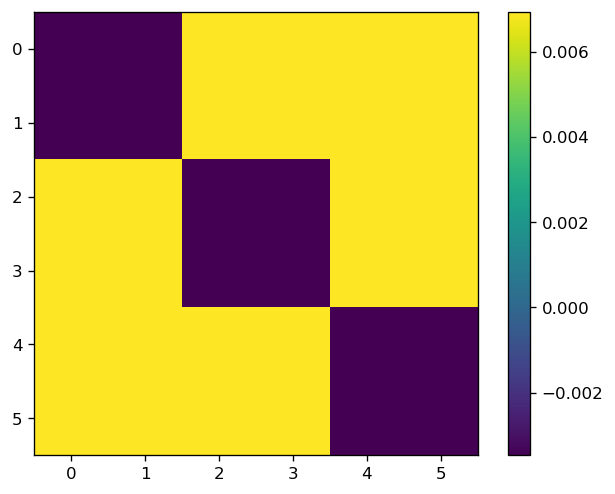

-0.0034722222573749066
[0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]


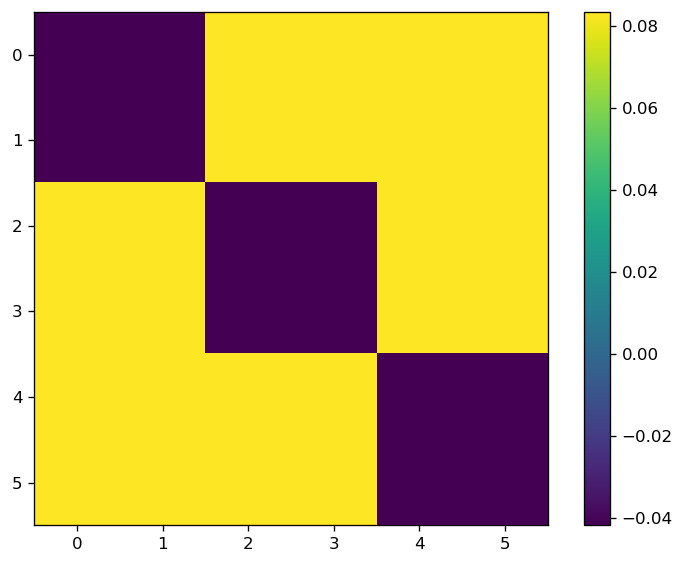

bigmat


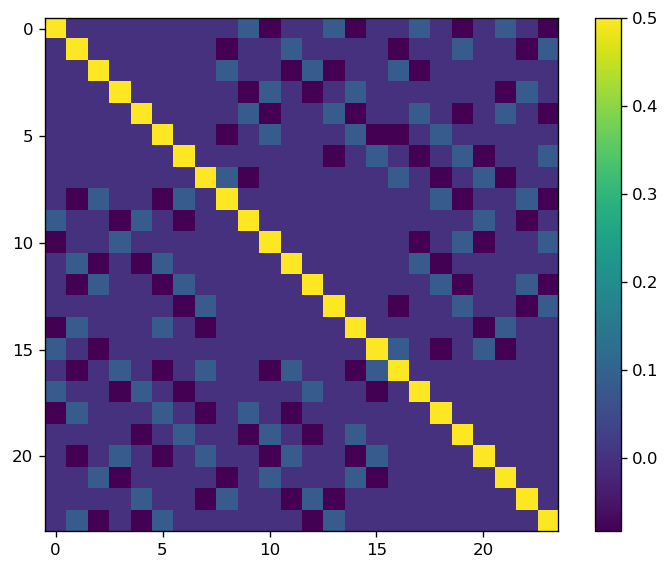

eig
0.9047347962240408


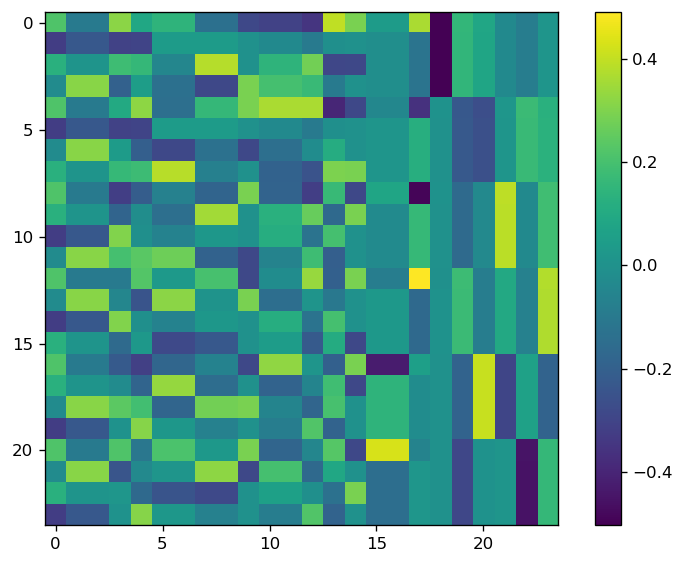

[ 0.21647264 -0.32039239  0.12862577 -0.02470602  0.21647264 -0.32039239
 -0.02470602  0.12862577  0.21647264  0.12862577 -0.32039239 -0.02470602
  0.21647264 -0.02470602 -0.32039239  0.12862577  0.21647264  0.12862577
 -0.02470602 -0.32039239  0.21647264 -0.02470602  0.12862577 -0.32039239]


In [279]:
def to_str(L):
    return ''.join([str(x) for x in L])
    


plt.imshow(Lambda)
plt.colorbar()
plt.show()
print(np.min(Lambda))
print(mu)
# print(len(set(prob.yes_instances)))
# print(prob.yes_instances)
# print(Lambda.shape)

# print(2*np.sum(Lambda))
# print(Lambda[0,1])
# print(np.linalg.eig(G))
G = to_adversary_mat(Lambda, mu)
# plt.imshow(G)
# plt.colorbar()
# plt.show()
# print(mat)
t = .5
visualize(G)
big_mat = np.kron(G*mat, np.ones((n ,n)))*oracle_diffs
big_mat = t*np.eye(big_mat.shape[0]) + big_mat
print('bigmat')
visualize(big_mat)
print('eig')
print(np.max(np.real(np.linalg.eigvals(big_mat))))
visualize(np.real(np.linalg.eig(big_mat)[1]).T)
print((np.real(np.linalg.eig(big_mat)[1][:, 0])))
# print(Lambda.shape)
# A,_ = adv_solver(prob)

In [280]:
A.visualize_matrix()
print(set(np.round(A.matrix.flatten(), 7)))
visualize(Lambda.T/np.sum(Lambda), ( prob.no_instances, prob.yes_instances), to_string=True)
print()
print(set(list(np.round(Lambda.flatten(), 7))))
print(np.min(Lambda))
print(Lambda)

NameError: name 'A' is not defined

In [281]:
print(G[0,1])

-0.04166666716544188


6 2
fac 0
0 0
0 1
0 2
0 3
0 4
0 5


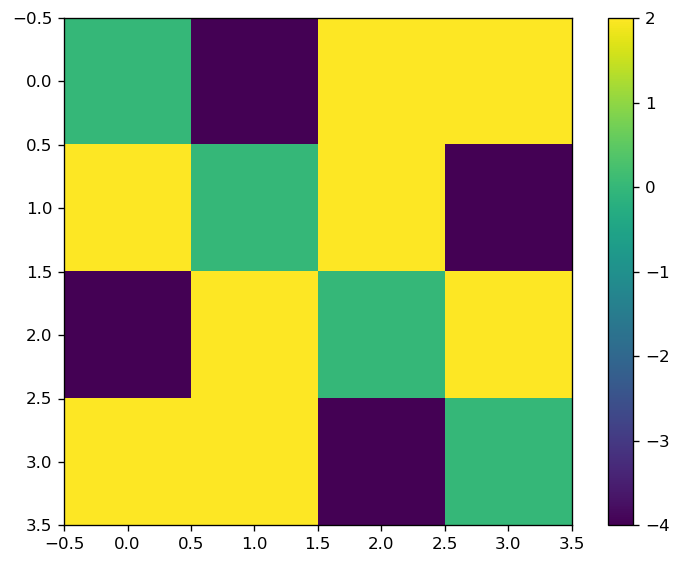

1 0
1 1
1 2
1 3
1 4
1 5


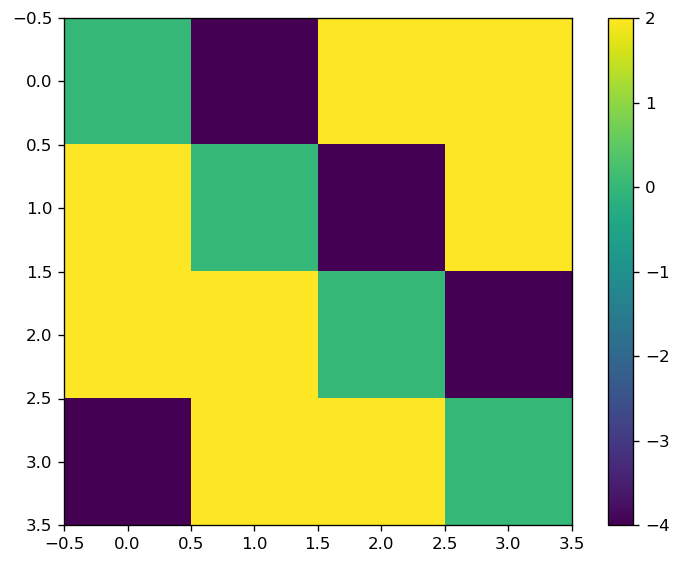

2 0
2 1
2 2
2 3
2 4
2 5


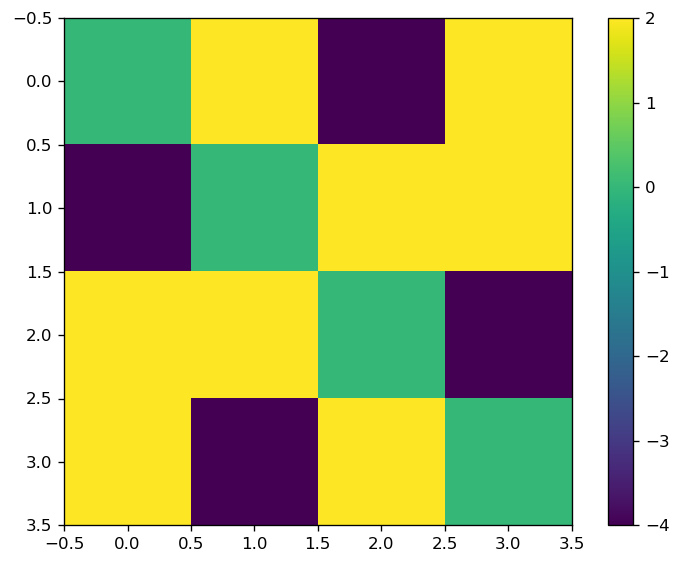

3 0
3 1
3 2
3 3
3 4
3 5


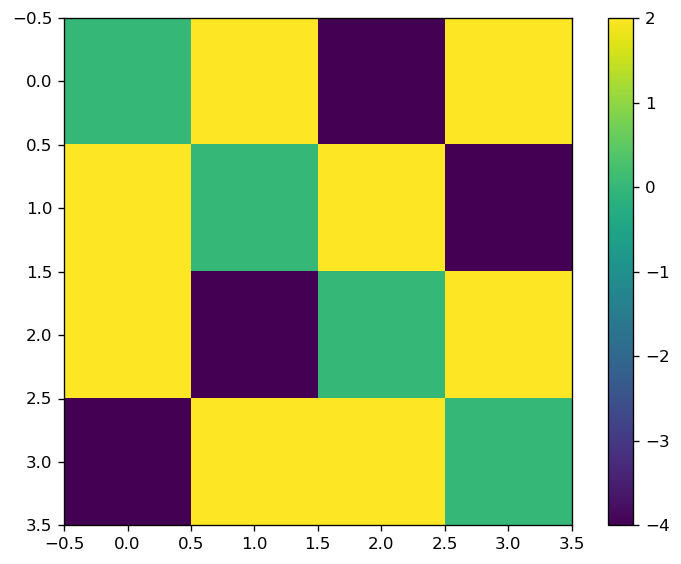

In [282]:
# print(oracle_diffs)
# print(oracle_diffs_list)
print(len(oracle_diffs_list), np.math.factorial(n-2))
fac = len(perm_types[0])
print('fac', fac)
for j in range(n):
    curr_sum =  np.zeros((n, n))
    for i in list(range(0, j*fac)) + list(range((j+1)*fac, len(oracle_diffs_list))):
        print(j, i)
        curr_sum = curr_sum + oracle_diffs_list[j][i]
    visualize(curr_sum)